# 1. IMPORT LIBRARIES

In [1]:
#!pip install -q datasets accelerate
#!pip install -q git+https://github.com/huggingface/transformers.git@main
# !pip install -q git+https://github.com/huggingface/peft.git
# !pip install -q bitsandbytes datasets accelerate loralib



#!pip install -q datasets accelerate
# !pip install -q git+https://github.com/huggingface/transformers.git@main
# !pip install -q git+https://github.com/huggingface/peft.git
# !pip install -q bitsandbytes datasets accelerate loralib
!pip install -q datasets
!pip install --upgrade transformers
!pip install tensorflow


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc
from torch.cuda.amp import autocast, GradScaler


from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, OPTForCausalLM, GPT2Tokenizer, AdamW, AutoModelForSequenceClassification

!pip install -q accelerate

# !pip install -q git+https://github.com/huggingface/transformers.git@main
# !pip install -q git+https://github.com/huggingface/peft.git
# !pip install -q bitsandbytes datasets accelerate loralib


import matplotlib.pyplot as plt
import pandas as pd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.6 MB/s eta 0:00:00


In [2]:

!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter


Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp767cj2ur".


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## 2. SET MAIN INPUTS FOR NOTEBOOK

In [4]:
bx_size = 1                                 # batch size for inference OR TRAIN with the OPT
format_train_val = 'gpt3'                   # 'minimal' or 'gpt3
task_name = 'mnli'                          # 'mnli'
model_name = "facebook/opt-350m"            # model options below
examples_per_exp =  16                       # 16
num_experiments = 10                         # 10
num_validations = 1024   # not used yet in this NB (when later on doing validation needs to be specified at 1024)

SEL_EXP_TRAIN_CD = 1                        # Select experiment to run


# model_name = "facebook/opt-125m"
# model_name = "facebook/opt-350m"
# model_name = "facebook/opt-1.3b"
# model_name = "facebook/opt-2.7b"
# model_name = "facebook/opt-6.7b"

## 2. SET DEVICE

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
import torch

# Check if CUDA (GPU support) is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

# If CUDA is available, print the GPU name(s)
if cuda_available:
    print(f"GPU Name(s): {torch.cuda.get_device_name(0)}")

CUDA Available: True
GPU Name(s): Tesla T4


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Select GPU device")
    device = torch.device("cuda")
else:
    print("Select GPU device")
    device = torch.device("cpu")

print(device)
# torch.cuda.is_available()

Select GPU device
cuda


## 3. IMPORT TOKENIZER AND SELECT MODEL

In [8]:
# Choose model to work with:

# model_name = "facebook/opt-125m"
# model_name = "facebook/opt-350m"
# model_name = "facebook/opt-1.3b"
# model_name = "facebook/opt-2.7b"
# model_name = "facebook/opt-6.7b"

model_name = model_name # it is set up in top of NB

In [9]:
OPT_tokenizer = GPT2Tokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

## 4. IMPORT NLI DATASET FOR TRAINING AND VALIDATION: MNLI

In [10]:
# reference: https://github.com/uds-lsv/llmft/blob/main/notebooks/majority_baseline.ipynb
# this reference is useful for cleaning the neutral sentences of the dataset, just keeping the 0 and 1.

In [11]:
from collections import Counter
from datasets import load_dataset, ClassLabel

In [12]:
# this comes from original paper, to remove neutral examples from MNLI
def binarize_mnli(dataset, remove_neutral=True):
    if remove_neutral:
        # neutral class has label 1
        dataset = dataset.filter(lambda example: example["label"] != 1)

    # change labels of contradiction examples from 2 to 1
    def change_label(example):
        # convert labels 2 into labels 1. this merges the neutral and contradiction class
        example["label"] = 1 if example["label"] == 2 else example["label"]
        return example

    # change labels
    dataset = dataset.map(change_label)

    # change features to reflect the new labels
    features = dataset["train"].features.copy()
    features["label"] = ClassLabel(num_classes=2, names=['entailment', 'contradiction'], id=None)
    dataset = dataset.cast(features)  # overwrite old features

    return dataset


In [13]:
dataset = load_dataset("glue", task_name)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [14]:
# binarize dataset
if task_name == "mnli":
    dataset = binarize_mnli(dataset, remove_neutral=True) # mnli


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/261802 [00:00<?, ? examples/s]

Map:   0%|          | 0/6692 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/261802 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6692 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6703 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9796 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [15]:
# analyze and visualize dataset imported

print("task_name:", task_name)
for split in ["train", "validation_matched"]:
    c = Counter(dataset[split]["label"])
    total = len(list(c.elements()))
    print("Total number of samples:", total)
    print(split)
    for k in c:
        print(f"fraction of labels per class: {k}={c[k] / total}")
print(dataset)

task_name: mnli
Total number of samples: 261802
train
fraction of labels per class: 0=0.49999236063895613
fraction of labels per class: 1=0.5000076393610439
Total number of samples: 6692
validation_matched
fraction of labels per class: 1=0.4801255230125523
fraction of labels per class: 0=0.5198744769874477
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 261802
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6692
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6703
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


In [16]:
# Perform the filters and splits from the original datasets


random_split_seed = 42

examples_per_exp =  examples_per_exp # set above 16
num_experiments = num_experiments # set above 10
num_validations = num_validations # set above 16*64 #64*16 = 1024 #6692

max_train_samples = examples_per_exp*num_experiments
train_dataset = dataset['train']
print(train_dataset)

train_dataset_yes_all = dataset['train'].filter(lambda example: example["label"] == 0)
train_dataset_no_all = dataset['train'].filter(lambda example: example["label"] == 1)
print(train_dataset_yes_all)
print(train_dataset_no_all)

val_dataset_all_indomain = dataset['validation_matched']

# randomly select a subset of the training data
max_train_samples = min(len(train_dataset), max_train_samples)

np.random.seed(random_split_seed)
indices_yes = np.random.choice(range(len(train_dataset_yes_all)), size=int(max_train_samples/2), replace=False)
print("indices_yes: ", indices_yes)

np.random.seed(random_split_seed+1)
indices_no = np.random.choice(range(len(train_dataset_no_all)), size=int(max_train_samples/2), replace=False)
print("indices_no: ", indices_no)

np.random.seed(random_split_seed+2)
indices_val_indomain = np.random.choice(range(len(val_dataset_all_indomain)), size=num_validations, replace=False)
print("indices_val: ", indices_val_indomain)

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})


Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130899
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130903
})
indices_yes:  [108195  86013  39482  39689  10288  11589  94511  78690  36953  74067
  93678  83921  83896  21665  76736    651  48482  40811 127490  49367
 121664  39918  60933 126502  65765  12966  33438   7201  19815  49187
  29116  48565 125127  60274  33985 130032 104535 120345 104033  44914
  89806  87143 103906  15697  29521   4906  46884  75442  57625  32365
  70562  78463  18684  45639  30223 118624  40945  75797  63681  77117
  16126 130579   2132 113346  68080   7433 120366 122242  75493  64389
  95467  86480  52323  42308 101738  51386 126981  27346  45655 121440]
indices_no:  [ 54039  34647  34994 102702  14063 110662  33077  24477  24337  19083
  61263 109299 107760  88071  22063  90740 113958   9163  45235  32885
  58399  59560 102582  10964  38283  16146  72067  55788  60576  21220
  41478 1

In [17]:
train_dataset_yes = train_dataset_yes_all.select(indices_yes)
train_dataset_no = train_dataset_no_all.select(indices_no)

val_dataset_indomain = val_dataset_all_indomain.select(indices_val_indomain)
print("Train Dataset Yes: ", train_dataset_yes)
print("Train Dataset No: ", train_dataset_no)
print("Validation Dataset (in-domain): ", val_dataset_indomain)

Train Dataset Yes:  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 80
})
Train Dataset No:  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 80
})
Validation Dataset (in-domain):  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 1024
})


In [18]:
# Calculate the number of 0 and 1 in validation dataset
# and calculate the majority class accuracy

val_dataset_indomain_yes = val_dataset_indomain.filter(lambda example: example["label"] == 0)
val_dataset_indomain_no = val_dataset_indomain.filter(lambda example: example["label"] == 1)
print(val_dataset_indomain_yes)
print(val_dataset_indomain_no)
print("Majority Class Accuracy: ", 100*max(len(val_dataset_indomain_yes), len(val_dataset_indomain_no))/(len(val_dataset_indomain_yes) + len(val_dataset_indomain_no)))

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 536
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 488
})
Majority Class Accuracy:  52.34375


In [19]:

format_train_val = format_train_val # set it at the top of notebook in a common place

def format_examples(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "gpt3" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset(train_ds_yes, train_ds_no, num_expts=num_experiments, num_train_examples=examples_per_exp):
    combined_dataset = []
    train_examples_yes = [example for example in train_ds_yes]
    train_examples_no = [example for example in train_ds_no]

    for irep in range(num_expts):
          sampled_train_exs_yes = train_examples_yes[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          sampled_train_exs_no = train_examples_no[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          merged_sampled_train_exs = sampled_train_exs_yes + sampled_train_exs_no
          shuffled_list = merged_sampled_train_exs.copy()
          random.seed(irep)
          random.shuffle(shuffled_list)

          for idx_shuffled_list in range(len(shuffled_list)):

            if shuffled_list[idx_shuffled_list]['label'] == 0:
              target_token = 9904
            else:
              target_token = 3084

            combined_ex = {'text': '', 'label': torch.tensor(shuffled_list[idx_shuffled_list]['label'], dtype=torch.long).to(device), 'exp': irep+1, 'target_token': torch.tensor(target_token, dtype=torch.long).to(device)}

            combined_ex['text'] += shuffled_list[idx_shuffled_list]['text']

            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn(batch):

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]
    target_tokens = [item['target_token'] for item in batch]

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.unsqueeze(torch.tensor(labels, dtype=torch.long).to(device),0)
    exps_tensor = torch.unsqueeze(torch.tensor(exps, dtype=torch.long).to(device),0)
    target_token_tensor = torch.unsqueeze(torch.tensor(target_tokens, dtype=torch.long).to(device),0)

    return {
        'text': texts,
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'label': labels_tensor,
        'exp': exps_tensor,
        'target_token': target_token_tensor
    }

class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [20]:

formatted_train_dataset_yes = train_dataset_yes.map(format_examples)
formatted_train_dataset_no = train_dataset_no.map(format_examples)

# print result to check correctness

combined_dataset = create_combined_dataset(
                                          train_ds_yes = formatted_train_dataset_yes,
                                          train_ds_no = formatted_train_dataset_no,
                                          num_expts=num_experiments,
                                          num_train_examples=examples_per_exp
                                           )

custom_dataset = CustomDataset(combined_dataset)
custom_dataset_experiment = CustomDataset([item for item in custom_dataset if item[0]['exp'] == SEL_EXP_TRAIN_CD])
print(custom_dataset_experiment)

# Last step, we create Dataloader passing the bx_size for inference/training (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_experiment = DataLoader(custom_dataset_experiment, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [21]:
# This is to inspect that the dataloader is performing as expected
# Also using the decoding to check back that results are expected and examples can be compared

# USE SIMILAR TO THIS TO PASS TO YOUR MODEL - SEE TENSOR DIMENSIONS AND ADJUST WITH SQUEEZE / UNSQUEEZE AS NEEDED THE DATALOADER OUTPUT AS INPUT TO YOUR MODEL

for i, batch in enumerate(dataloader_experiment):
    if i<200:
      print("Item Number: ", i, "experiment#: ", batch['exp'])
      print("DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
      print("Labels: ", batch['label'])
      print("Target Token: ", batch['target_token'])
      print("Input_ids: ", batch['input_ids'])
      print("Attention_Mask: ", batch['attention_mask'])
    else:
      break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Item Number:  0 experiment#:  tensor([[1]], device='cuda:0')
DETOKENIZE:  ['</s>{The chief complaint of reformers these days is that the power of special-interest money is breeding public cynicism about the political process.} question: {Reformers never complain about special interest money.  } Yes or No? answer: Ġ']
Labels:  tensor([[1]], device='cuda:0')
Target Token:  tensor([[3084]], device='cuda:0')
Input_ids:  tensor([[    2, 45152,   133,   834,  3674,     9,  3114,   268,   209,   360,
            16,    14,     5,   476,     9,   780,    12, 15979,   418,    16,
         16828,   285, 39245,    59,     5,   559,   609, 49463,   864,    35,
         25522,  9064,  3899,   268,   393, 11316,    59,   780,   773,   418,
             4,  1437, 35524,  3216,    50,   440,   116,  1948,    35,  4236,
         21402]])
Attention_Mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# IN-DOMAIN VALIDATION DATASET

In [22]:

def create_combined_dataset_indomain_VALIDATION(val_dataset, num_expts=num_experiments):
    combined_dataset = []

    for irep in range(num_expts):
      for val_ex in val_dataset:

            if val_ex['label'] == 0:
              target_token = 9904
            else:
              target_token = 3084

            combined_ex = {'text': '', 'label': torch.tensor(val_ex['label'], dtype=torch.long).to(device), 'exp': irep+1, 'target_token': torch.tensor(target_token, dtype=torch.long).to(device)}

            combined_ex['text'] += val_ex['text']

            # Append the new combined example to the combined dataset
            combined_dataset.append([combined_ex])

    return combined_dataset


In [23]:
formatted_val_dataset_indomain = val_dataset_indomain.map(format_examples)

combined_dataset_INDOMAIN_VALIDATION = create_combined_dataset_indomain_VALIDATION(
                                          val_dataset = formatted_val_dataset_indomain,
                                          num_expts=num_experiments
                                           )

custom_dataset_indomain_validation = CustomDataset(combined_dataset_INDOMAIN_VALIDATION)
custom_dataset_indomain_val_experiment = CustomDataset([item for item in custom_dataset_indomain_validation if item[0]['exp'] == SEL_EXP_TRAIN_CD])
print(custom_dataset_indomain_val_experiment)

# Last step, we create Dataloader passing the bx_size for inference/training (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_indomain_val_experiment = DataLoader(custom_dataset_indomain_val_experiment, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [24]:

for i, batch in enumerate(dataloader_indomain_val_experiment):
    if i<20:
      print("Item Number: ", i, "experiment#: ", batch['exp'])
      print("DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
      print("Labels: ", batch['label'])
      print("Target Token: ", batch['target_token'])
      print("Input_ids: ", batch['input_ids'])
      print("Attention_Mask: ", batch['attention_mask'])
    else:
      break

Item Number:  0 experiment#:  tensor([[1]], device='cuda:0')
DETOKENIZE:  ["</s>{no it didn't} question: {Yes it did.} Yes or No? answer: Ġ"]
Labels:  tensor([[1]], device='cuda:0')
Target Token:  tensor([[3084]], device='cuda:0')
Input_ids:  tensor([[    2, 45152,  2362,    24,   399,    75, 24303,   864,    35, 25522,
          9904,    24,   222, 49463,  3216,    50,   440,   116,  1948,    35,
          4236, 21402]])
Attention_Mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Item Number:  1 experiment#:  tensor([[1]], device='cuda:0')
DETOKENIZE:  ["</s>{Who? asked Tommy.} question: {Tommy didn't know, who.} Yes or No? answer: Ġ"]
Labels:  tensor([[0]], device='cuda:0')
Target Token:  tensor([[9904]], device='cuda:0')
Input_ids:  tensor([[    2, 45152, 12375,   116,   553,  8880, 49463,   864,    35, 25522,
         15691,  4783,   399,    75,   216,     6,    54, 49463,  3216,    50,
           440,   116,  1948,    35,  4236, 21402]])
Attention

In [25]:
# Custom model class for sequence classification

import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class OPT_VanillaFT(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        return logits

In [26]:
# Define optimizer and loss function
model = OPT_VanillaFT(model_name, num_labels=2)
# print(model)
optimizer = AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model.to(device)
model.train()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 25
batch_size = 1  # Reduce batch size to 4
for epoch in range(num_epochs):
    print("epoch: ", epoch)
    total_loss = 0.0
    train_acc = 0.0
    for i, batch in enumerate(dataloader_experiment):

        # print("input_ids: ", batch["input_ids"])


        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device).squeeze(0)


        # print("labels: ", batch["label"], labels.shape)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, None, labels) #, labels=labels)
        labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
        # print("outputs SHAPE: ", outputs.shape)
        # print(outputs)
        # # Compute loss
        loss = criterion(outputs, labels)
        # print("loss: ", loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute accuracy
        train_acc = train_acc + 1*(torch.argmax(outputs, dim=1).item()==batch["label"].to(device).squeeze(0).item())

    average_loss = total_loss / (i+1)
    train_losses.append(average_loss)
    train_accuracies.append(train_acc / (i+1))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.6f}, Accuracy: {train_accuracies[-1]:.9f}")

    # val_losses.append(val_loss / num_validations)
    # val_accuracies.append(val_accuracy / num_validations)

    # print(f"Validation Loss: {val_losses[-1]:.6f}, Validation Accuracy: {val_accuracies[-1]:.9f}")

    # model.train()


pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch:  0
Epoch 1/25, Train Loss: 1.325655, Accuracy: 0.500000000
epoch:  1
Epoch 2/25, Train Loss: 0.893191, Accuracy: 0.375000000
epoch:  2
Epoch 3/25, Train Loss: 0.706595, Accuracy: 0.500000000
epoch:  3
Epoch 4/25, Train Loss: 0.566728, Accuracy: 0.625000000
epoch:  4
Epoch 5/25, Train Loss: 0.573443, Accuracy: 0.687500000
epoch:  5
Epoch 6/25, Train Loss: 0.441032, Accuracy: 0.875000000
epoch:  6
Epoch 7/25, Train Loss: 0.462503, Accuracy: 0.875000000
epoch:  7
Epoch 8/25, Train Loss: 0.377643, Accuracy: 0.812500000
epoch:  8
Epoch 9/25, Train Loss: 0.216633, Accuracy: 0.937500000
epoch:  9
Epoch 10/25, Train Loss: 0.203064, Accuracy: 0.937500000
epoch:  10
Epoch 11/25, Train Loss: 0.141419, Accuracy: 1.000000000
epoch:  11
Epoch 12/25, Train Loss: 0.070098, Accuracy: 1.000000000
epoch:  12
Epoch 13/25, Train Loss: 0.067895, Accuracy: 1.000000000
epoch:  13
Epoch 14/25, Train Loss: 0.051440, Accuracy: 1.000000000
epoch:  14
Epoch 15/25, Train Loss: 0.042067, Accuracy: 1.000000000

In [27]:
# Validation
model.eval()
val_loss = 0.0
val_accuracy = 0.0
with torch.no_grad():
    for batch in dataloader_indomain_val_experiment:
        src = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device).squeeze(0)

        # Forward pass
        outputs = model(input_ids, None, labels)

        # Compute loss
        # if 'logits' in outputs:
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Compute accuracy
        val_accuracy += 1*(torch.argmax(outputs, dim=1).item()==batch["label"].to(device).squeeze(0).item())
    val_loss = val_loss/num_validations
    val_accuracy = val_accuracy/num_validations
    print(f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.9f}")


Validation Loss: 3.657466, Validation Accuracy: 0.476562500


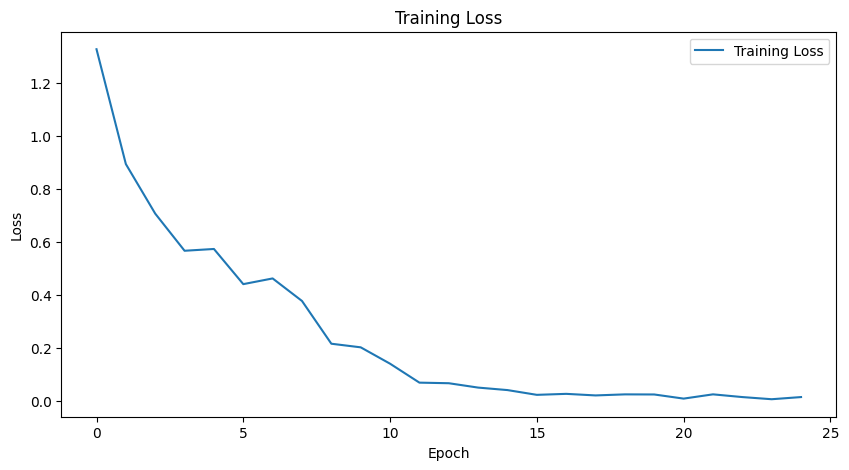

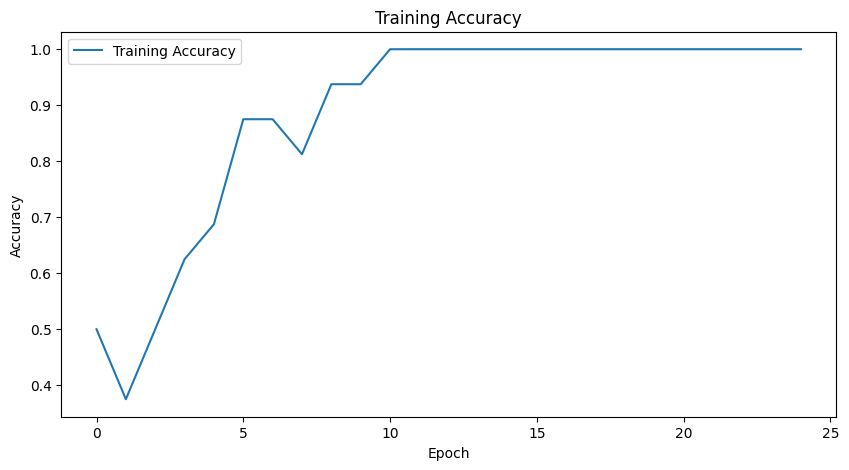

In [28]:
# @title
torch.save(model.state_dict(), "finetuned_opt.bin")
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
#plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()



# Plot training accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()


In [29]:
dataset_ood = load_dataset("hans")
dataset_ood

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
        num_rows: 30000
    })
})

In [30]:
dataset_ood_val = (dataset_ood['validation']).filter(lambda example: example["heuristic"] == 'lexical_overlap')

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [31]:
# Perform the filters and splits from the original datasets


random_split_seed_ood = 42 # set above, equal to 42

examples_per_exp =  examples_per_exp # 16
num_experiments = num_experiments # 10
num_validations = num_validations # 16*64 #64*16 = 1024 #6692

np.random.seed(random_split_seed_ood)
indices_ood_val = np.random.choice(range(len(dataset_ood_val)), size=num_validations, replace=False)
print("indices_ood_val: ", indices_ood_val)

dataset_ood_val_sel = dataset_ood_val.select(indices_ood_val)
dataset_ood_val_sel

indices_ood_val:  [6252 4684 1731 ... 9410 1671  474]


Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 1024
})

In [32]:
# format examples functions formats according to different types of formats for ICL both training and validation examples

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place


def format_examples_validation_VALOOD(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset(val_dataset, num_expts=num_experiments):
    combined_dataset = []

    for irep in range(num_expts):
      for val_ex in val_dataset:

        combined_ex = {'text': '', 'label': torch.tensor(val_ex['label'], dtype=torch.long).to(device), 'exp': irep+1}

        combined_ex['text'] += val_ex['text']

        combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_VALOOD(batch):
    # This function is created to be able to tokenize dynamically to max length within each batch
    # Also, by modifying the tokenizer used, several other options are available
    # for example, if we set padding to a specified max_length, for example the model max_length, is also an option, not the default though
    # the default is the dynamic padding

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")

    labels_tensor = torch.unsqueeze(torch.tensor(labels, dtype=torch.long).to(device),0)
    exps_tensor = torch.unsqueeze(torch.tensor(exps, dtype=torch.long).to(device),0)

    return {
        'text': texts,
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'label': labels_tensor,
        'exp': exps_tensor,
    }


class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [33]:
# First the samples are formatted according to selection above
# Important to check selection and re-run cell above so that it is taken by the mapping function correctly

formatted_val_dataset_ood = dataset_ood_val_sel.map(format_examples_validation_VALOOD)

# Initialize custom dataset with the combined dataset
# print result to check correctness

combined_dataset_VALOOD = create_combined_dataset(
                                          val_dataset = formatted_val_dataset_ood,
                                          num_expts=num_experiments
                                           )

custom_dataset_VALOOD = CustomDataset(combined_dataset_VALOOD)
print(custom_dataset_VALOOD)

custom_dataset_VALOOD_EXP = CustomDataset([item for item in custom_dataset_VALOOD if item[0]['exp'] == SEL_EXP_TRAIN_CD])

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_VALOOD = DataLoader(custom_dataset_VALOOD_EXP, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_VALOOD, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [34]:
# Validation
model.eval()
val_loss = 0.0
val_accuracy = 0.0
with torch.no_grad():
    for batch in dataloader_VALOOD:
        # print(batch)

        src = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device).squeeze(0)

        # Forward pass
        outputs = model(input_ids, None, labels)

        # Compute loss
        # if 'logits' in outputs:
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        # break

        # Compute accuracy
        val_accuracy += 1*(torch.argmax(outputs, dim=1).item()==batch["label"].to(device).squeeze(0).item())
    val_loss = val_loss/num_validations
    val_accuracy = val_accuracy/num_validations
    print(f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.9f}")


Validation Loss: 3.534672, Validation Accuracy: 0.494140625
